Finding the products that are likely to be purchased together in a bakery...Using Associate rule mining I will mine the association.

In [1]:
#### import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import data..

The dataset consists of 21293 observations from a bakery. The data file contains four variables, Date, Time, Transaction ID and Item. 

In [0]:
###  Loading the  data
data=pd.read_csv('BreadBasket_DMS.csv')

In [3]:
### previewing our dataset
data.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [4]:
##### data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


In [5]:
## descriptive statistics
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Transaction,21293.0,4951.990889,2787.7584,1.0,2548.0,5067.0,7329.0,9684.0


The transactions are 21293 with a mean of 4952 transactions.

In [6]:
### looking for null values
data.isnull().sum()

Date           0
Time           0
Transaction    0
Item           0
dtype: int64

In [7]:
### transactions
data['Transaction'].unique()
### we have 9684 unique transar

array([   1,    2,    3, ..., 9682, 9683, 9684])

In [8]:
### duplicates in our data..
data[data.duplicated()]
## we have  1653 duplicated transactions in our data.

,Date,Time,Transaction,Item
2,2016-10-30,10:05:34,2,Scandinavian
25,2016-10-30,10:27:21,11,Bread
39,2016-10-30,10:34:36,15,NONE
52,2016-10-30,10:49:29,21,Coffee
107,2016-10-30,12:23:01,49,Coffee
...,...,...,...,...
21173,2017-04-08,15:04:45,9618,Cake
21187,2017-04-08,16:05:07,9627,Coffee
21206,2017-04-08,16:30:32,9634,Coffee
21248,2017-04-09,11:40:10,9664,Coffee


In [9]:
#### drop the duplicates 
data.drop_duplicates()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
5,2016-10-30,10:07:57,3,Cookies
...,...,...,...,...
21288,2017-04-09,14:32:58,9682,Coffee
21289,2017-04-09,14:32:58,9682,Tea
21290,2017-04-09,14:57:06,9683,Coffee
21291,2017-04-09,14:57:06,9683,Pastry


In [10]:
## the unique items we have
data['Item'].unique()
## we have 'none' as an item, so its best if we dropped it
data=data.drop(data[data['Item']=='NONE'].index)
data

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
...,...,...,...,...
21288,2017-04-09,14:32:58,9682,Coffee
21289,2017-04-09,14:32:58,9682,Tea
21290,2017-04-09,14:57:06,9683,Coffee
21291,2017-04-09,14:57:06,9683,Pastry


In [0]:
### lets split the  date to get the months
data['month']=pd.DatetimeIndex(data['Date']).month
data['month'].unique()
def label_month(month):
  if month == 1:
    return 'Jan'
  elif month == 2:
    return 'Feb'
  elif month == 3:
    return 'March'
  elif month == 4:
    return 'April'
  elif month == 10:
    return "Oct"
  elif month == 11:
    return "Nov"
  elif month == 12:
    return "Dec"
data['month']=data['month'].apply(label_month)



In [0]:
## creating a column to see which day of the week it is
data['datetime']=pd.to_datetime(data['Date']+" "+data['Time'])
data['week']=data['datetime'].dt.week
data['weekday']=data['datetime'].dt.weekday
data['hour']=data['datetime'].dt.hour

In [0]:
##### creating the day of the week
def day(weekday):
  if weekday == 0:
    return 'Mon'
  elif weekday == 1:
    return 'Tue'
  elif weekday == 2:
    return 'Wed'
  elif weekday == 3:
    return 'Thur'
  elif weekday == 4:
    return "Fri"
  elif weekday == 5:
    return "Sat"
  elif weekday == 6:
    return "Sun"
data['day']=data['weekday'].apply(day)

Lets do some EDA to learn more about our bakery data,

Coffee           5471
Bread            3325
Tea              1435
Cake             1025
Pastry            856
Sandwich          771
Medialuna         616
Hot chocolate     590
Cookies           540
Brownie           379
Name: Item, dtype: int64


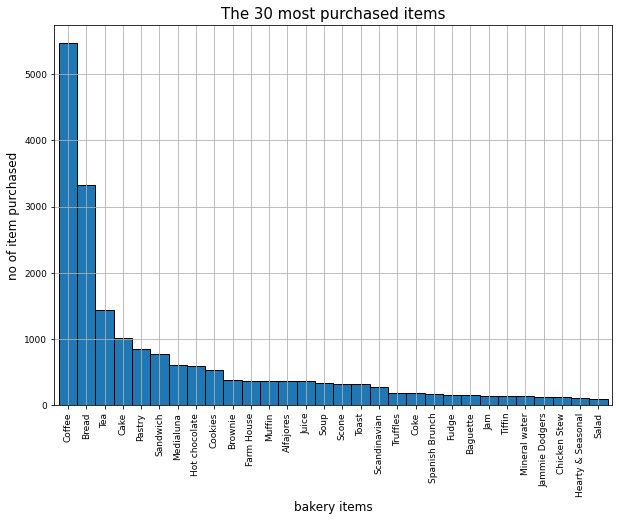

In [14]:
#### The best selling
fig,ax=plt.subplots(figsize=(10,7))
item=data['Item'].value_counts().sort_values(ascending=False).head(30)
item.plot.bar(width=1,edgecolor='k',align='center',linewidth=1)
ax.tick_params(labelsize=9)
plt.xlabel('bakery items',fontsize=12)
plt.ylabel('no of item purchased',fontsize=12)
plt.title('The 30 most purchased items',fontsize=15)
plt.ioff()
plt.grid()
print(item.head(10))

Coffee, bread, tea, cake and pastry were there most purchased items in the bakery. Lets see if the coffee and bread and cake are bought together or with tea


Text(0.5, 1.0, 'Number of item sold per month')

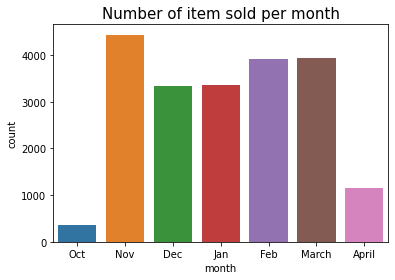

In [15]:
### number of items purchased by month
sns.countplot(x='month',data=data,orient='v').set_title('Number of item sold per month',fontsize=15)

Text(0.5, 1.0, 'number of item purchased per hour')

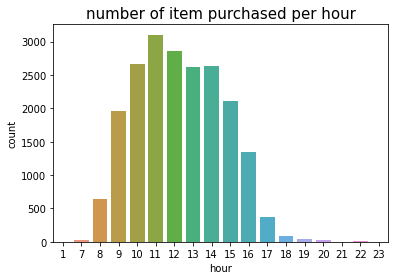

In [16]:
##### number of item purchased during the hour
sns.countplot(x='hour',data=data).set_title('number of item purchased per hour',fontsize=15)

Text(0.5, 1.0, 'Number of items purchased per day')

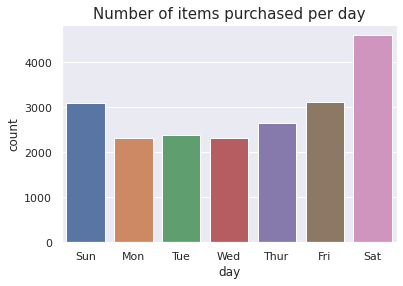

In [17]:
### number of items purchased in the weekdays
sns.set(palette='deep',style='darkgrid')
sns.countplot(x='day',data=data).set_title('Number of items purchased per day',fontsize=15)

Most of the  products were purchased between 9am and 3am, and the weekends is when we had have alot of customers.

Lets  do associate rule mining to uncover the which items are purchased together

In [18]:
#### grouping our data.
# this helps to transsform the data into transactional data. each row is transaction
df=data.groupby(['Transaction','Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('Transaction')
df.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,...,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
### cleaning the transactio
def encode(x):
  if x <=0:
    return 0
  if x >= 1:
    return 1
df=df.applymap(encode)

In [20]:
#### creating the rules
freq_item=apriori(df,min_support=0.05,use_colnames=True)
freq_item.sort_values(by='support',ascending=False)

,support,itemsets
2,0.478394,(Coffee)
0,0.327205,(Bread)
8,0.142631,(Tea)
1,0.103856,(Cake)
9,0.090016,"(Coffee, Bread)"
6,0.086107,(Pastry)
7,0.071844,(Sandwich)
5,0.061807,(Medialuna)
4,0.058320,(Hot chocolate)
10,0.054728,"(Cake, Coffee)"


Support is how frequently the item appears in the dataset.
confidence is how often the rules have been found true
From above we can see that coffee has the highest support, then bread, tea and cake. Hence this confirms what we had plotted earlier


In [21]:
#### creating the rules
rules=association_rules(freq_item,metric='confidence',min_threshold=0.01).sort_values(by='confidence',ascending=0)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
1,(Bread),(Coffee),0.327205,0.478394,0.090016,0.275105,0.575059,-0.066517,0.719561
0,(Coffee),(Bread),0.478394,0.327205,0.090016,0.188163,0.575059,-0.066517,0.828731
3,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905


We can see that cake and coffee are most likely to be purchased together also coffee and bread. Cake and coffee have a confidence of 0.53 this shows that 53% of transactions of cake they contain coffee and a lift of 1.1,so cake is 1.1 likely to be bought with coffee. 27% of the bread transactions were with coffee, with a lift of 0.58, shows that 0.58 probability of bread being bought with coffee